In [4]:
import pandas as pd

# โหลดข้อมูลจาก CSV
data1 = pd.read_csv("merge.csv")
data2 = pd.read_csv("2013-2017.csv")
# ตรวจสอบข้อมูล
print(data1.shape)
print(data2.shape)



(1360306, 8)
(18328, 8)


In [5]:
data1.drop_duplicates(subset=['title','city','country'],inplace=True)
print(data1.shape)
data2.drop_duplicates(subset=['title','city','country'],inplace=True)
print(data2.shape)

(42011, 8)
(4582, 8)


In [6]:


# Combine data1 and data2
combined_data = pd.concat([data1, data2], ignore_index=True)

# Check the shape of the combined DataFrame
print(combined_data.shape)

# Optional: Remove duplicates after combining (if necessary)
combined_data.drop_duplicates(subset=['title','city','country'], inplace=True)
print(combined_data.shape)


(46593, 8)
(46593, 8)


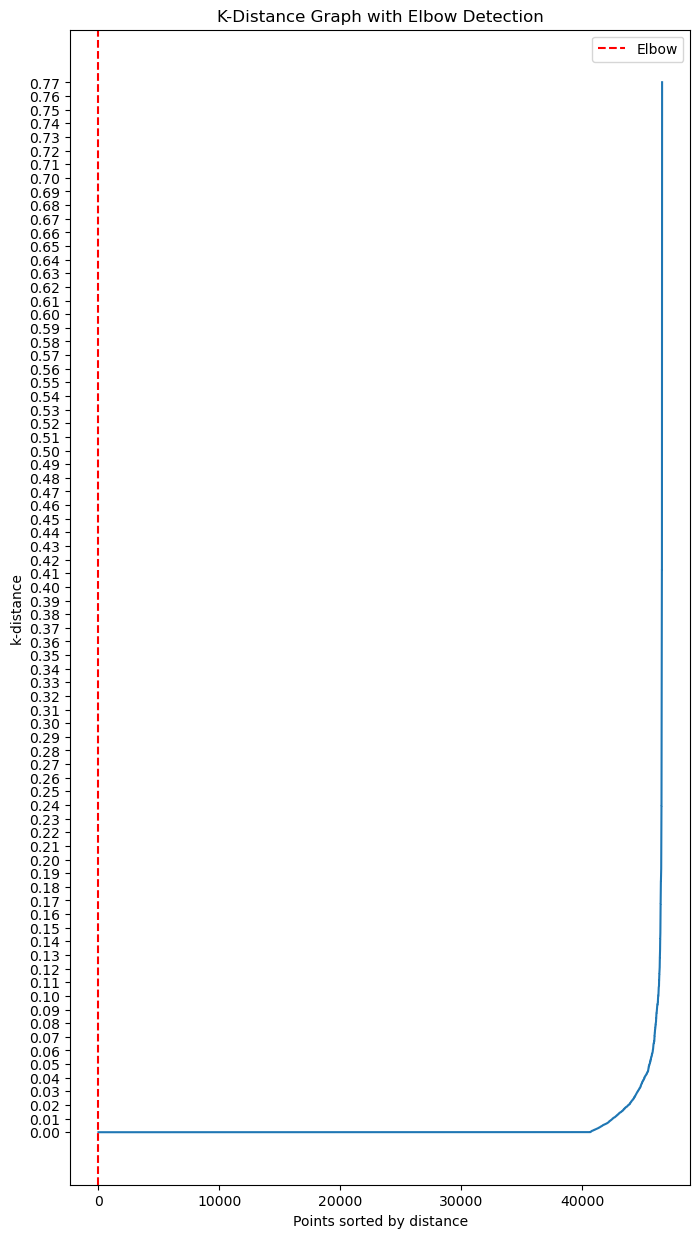

In [23]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

# ใช้เฉพาะค่าพิกัดสำหรับ Clustering
coordinates = combined_data[["latitude", "longitude"]]

# Standardize ข้อมูล
scaler = StandardScaler()
coordinates_scaled = scaler.fit_transform(coordinates)

# คำนวณ k-distance เพื่อเลือกค่า eps
neighbors = NearestNeighbors(n_neighbors=10)  # กำหนดจำนวน k
neighbors_fit = neighbors.fit(coordinates_scaled)
distances, indices = neighbors_fit.kneighbors(coordinates_scaled)

# Plot k-distance graph
distances = np.sort(distances[:, -1])  # ใช้ระยะของ k-th neighbor
plt.figure(figsize=(8, 15))
plt.plot(distances)
plt.axvline(x=np.argmin(np.diff(distances)), color='r', linestyle='--', label="Elbow")
plt.title('K-Distance Graph with Elbow Detection')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')

# เพิ่มความละเอียดให้กับแกน Y
plt.yticks(np.arange(min(distances), max(distances), step=0.01))  # ปรับค่า step ตามความละเอียดที่ต้องการ

plt.legend()
plt.show()




ผลลัพธ์ของ Clustering:
                      author_name  \
0              C. Rujitharanawong   
1      Pakkaporn Rungruengkultorn   
2           Chonchanok Muangnapoh   
3              Narut Prasitlumkum   
4               Danaithep Limskul   
...                           ...   
46588              Matrisciano A.   
46589                   Kvočka D.   
46590                 Talpur B.A.   
46591                 Skryabin A.   
46592                  Marupov I.   

                                             affiliation           city  \
0                                       Siriraj Hospital        Bangkok   
1                               Chulalongkorn University        Bangkok   
2               Mahidol University, Faculty of Dentistry        Bangkok   
3                    University of California, Riverside      Riverside   
4                   King Chulalongkorn Memorial Hospital        Bangkok   
...                                                  ...            ...   
46588  

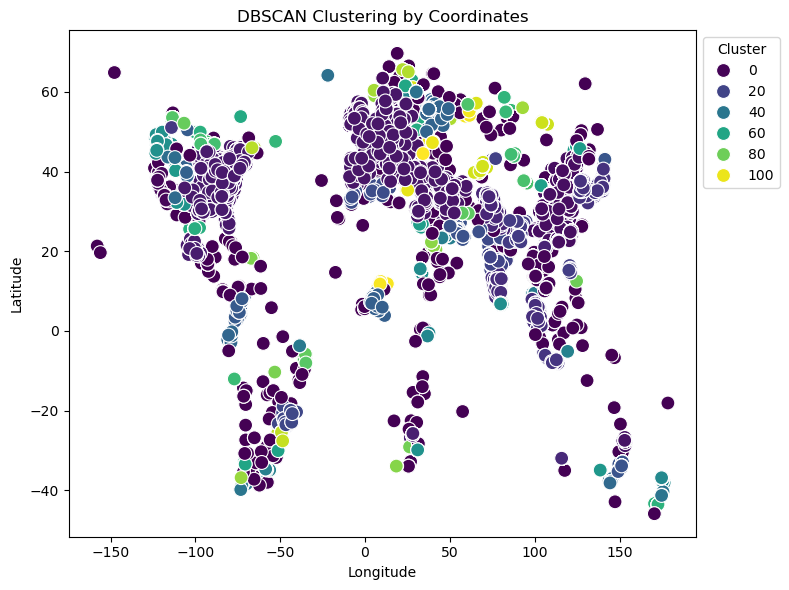

In [35]:
# เลือกค่า eps จากกราฟ (สมมุติ eps = 0.5)
dbscan = DBSCAN(eps=0.06, min_samples=10)  # กำหนดค่า eps และ min_samples
clusters = dbscan.fit_predict(coordinates_scaled)

# เพิ่มผลลัพธ์ Clustering ลงใน DataFrame
combined_data["Cluster"] = clusters

# แสดงผลลัพธ์ Clustering
print("ผลลัพธ์ของ Clustering:")
print(combined_data)

# การแสดงกราฟ Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="longitude",
    y="latitude",
    hue="Cluster",
    palette="viridis",
    data=combined_data,
    s=100
)
plt.title("DBSCAN Clustering by Coordinates")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [36]:
combined_data['Cluster'].value_counts().sort_values(ascending=False)

Cluster
0      15458
5       9033
3       6611
6       4559
14      1814
       ...  
102       11
80        11
86        10
83        10
45        10
Name: count, Length: 105, dtype: int64

In [39]:
combined_data.to_csv('data_with_cluster.csv',index=False)

In [54]:
import joblib
from sklearn.preprocessing import LabelEncoder
import pandas as pd
df = pd.read_csv('data_with_cluster.csv')
# Load the label encoder
le = LabelEncoder()
le.fit_transform(df['Cluster'])

def predict_cluster(title):
    model = joblib.load('model/model_with_stopwords_removed.joblib')
    prediction = model.predict([title])  # ทำนาย cluster จาก title
    return le.inverse_transform(prediction)  # แปลงผลลัพธ์กลับเป็น label เดิม

# ตัวอย่างการใช้ฟังก์ชั่น
title_input = "AI"
predicted_cluster = predict_cluster(title_input)
print(f"The title belongs to cluster: {predicted_cluster[0]}")


The title belongs to cluster: 5


In [62]:
df['Cluster'].value_counts()

Cluster
0      15458
5       9033
3       6611
6       4559
14      1814
       ...  
102       11
80        11
86        10
83        10
45        10
Name: count, Length: 105, dtype: int64

In [61]:
# คำนวณจำนวนของแต่ละ Cluster
cluster_counts = df['Cluster'].value_counts()

# เลือก Cluster ที่มีจำนวนมากกว่า 1000
clusters_to_keep = cluster_counts[cluster_counts > 1000].index

# กรองข้อมูลที่อยู่ใน clusters ที่มีจำนวนมากกว่า 1000
filtered_df = df[df['Cluster'].isin(clusters_to_keep)]

# แสดงผลลัพธ์
print(filtered_df["Cluster"].value_counts())

Cluster
0     15458
5      9033
3      6611
6      4559
14     1814
13     1077
Name: count, dtype: int64


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import joblib
import string
import nltk
from nltk.corpus import stopwords  # เพิ่มการ import stopwords

# โหลด stopwords จาก nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ฟังก์ชั่นสำหรับการตัดคำ stopwords
def remove_stopwords(text):
    # ตัดเครื่องหมายวรรคตอน
    text = ''.join([char for char in text if char not in string.punctuation])
    # แปลงข้อความเป็นตัวพิมพ์เล็กทั้งหมด
    text = text.lower()
    # ตัดคำ stopwords
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# เตรียมข้อมูล (ตัวอย่าง)
import pandas as pd


# เตรียมข้อมูล
filtered_df['title'] = filtered_df['title'].apply(remove_stopwords)

# การทำ Label Encoding สำหรับ Cluster
le = LabelEncoder()
filtered_df['Cluster'] = le.fit_transform(filtered_df['Cluster'])  # label encoding สำหรับ Cluster

# ข้อมูล Features และ Labels
X = filtered_df['title']  # ข้อความ (title)
y = filtered_df['Cluster']  # คลัสเตอร์ที่เกิดจาก DBSCAN

# แบ่งข้อมูลเป็น training set และ test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้าง pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.8)),  # แปลงข้อความเป็นเวกเตอร์
    ('clf', SVC(kernel='linear', C=1, gamma='scale', probability=True))  # ใช้ SVM กับ kernel แบบ linear
])

# ฝึกโมเดล
pipeline.fit(X_train, y_train)

# ทดสอบ accuracy
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# บันทึกโมเดล
joblib.dump(pipeline, 'model/model_with_stopwords_removed_without_thousand_again.joblib')

# ใช้โมเดลในการทำนาย cluster จากข้อความใหม่
def predict_cluster(title):
    model = joblib.load('model/model_with_stopwords_removed_without_thousand_again.joblib')
    prediction = model.predict([title])  # ทำนาย cluster จาก title
    return le.inverse_transform(prediction)  # แปลงผลลัพธ์กลับเป็น label เดิม

# ตัวอย่างการใช้ฟังก์ชั่น
title_input = "Enter your keyword or title here"
predicted_cluster = predict_cluster(title_input)
print(f"The title belongs to cluster: {predicted_cluster[0]}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PREDATOR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_31644\2994635224.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['title'] = filtered_df['title'].apply(remove_stopwords)
C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_31644\2994635224.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Cluster'] = le.fit_transform(filte

Accuracy: 0.6026455712618337
The title belongs to cluster: 0


In [68]:
title_input = "chulalongkorn"
predicted_cluster = predict_cluster(title_input)
print(f"The title belongs to cluster: {predicted_cluster[0]}")

The title belongs to cluster: 0
